In [91]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import pandas as pd
#import rasterio
from sklearn.utils import shuffle
import PIL

import os
import sys
from shutil import copyfile, move
from tqdm import tqdm
import h5py
import random
from random import randint

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, Reshape, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import ResNet50, VGG16
from keras.losses import mean_squared_error
import keras as K
from sklearn.metrics import cohen_kappa_score

In [92]:
data = pd.read_pickle("C:/Users/m.alvarezg1/Downloads/dataF2_MC.pkl")
data

,id,tipoinmueble,banos,estado,estrato,garajes,habitaciones,piso,tiempodeconstruido,areaconstruida,latitud,longitud,valorventa,imagenes
189128,721536.0,Apartamento,2.0,Usado,3.0,1.0,3.0,3.0,Entre 5 y 10 años,76.0,4.751413,-74.091550,289000000.0,"[""https://metrocuadrado.blob.core.windows.net/..."
189129,721537.0,Apartamento,2.0,Usado,4.0,1.0,3.0,5.0,Entre 5 y 10 años,72.0,4.648093,-74.103546,450000000.0,"[""https://metrocuadrado.blob.core.windows.net/..."
189130,721538.0,Apartamento,4.0,Usado,6.0,2.0,3.0,3.0,Entre 10 y 20 años,220.0,4.708651,-74.025696,1300000000.0,"[""https://metrocuadrado.blob.core.windows.net/..."
189133,721541.0,Apartamento,3.0,Usado,6.0,2.0,2.0,4.0,Entre 0 y 5 años,120.0,4.680367,-74.052155,1150000000.0,"[""https://metrocuadrado.blob.core.windows.net/..."
189134,721542.0,Apartamento,1.0,Usado,3.0,1.0,3.0,3.0,Entre 10 y 20 años,55.86,4.636661,-74.125410,260000000.0,"[""https://metrocuadrado.blob.core.windows.net/..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14558,1891581.0,Apartamento,1.0,Usado,3.0,0.0,2.0,24.0,Entre 0 y 5 años,41.9,4.583887,-74.156044,130000000.0,"[""https://metrocuadrado.blob.core.windows.net/..."
14563,1891586.0,Casa,2.0,Usado,2.0,0.0,3.0,2.0,Entre 10 y 20 años,73.0,4.533765,-74.083990,60000000.0,"[""https://metrocuadrado.blob.core.windows.net/..."
14570,1891593.0,Apartamento,2.0,Usado,2.0,0.0,3.0,6.0,Entre 10 y 20 años,47.0,4.653697,-74.155106,117425000.0,"[""https://metrocuadrado.blob.core.windows.net/..."
14576,1891599.0,Casa,2.0,Usado,2.0,0.0,5.0,2.0,Más de 20 años,148.0,4.568058,-74.080020,150000000.0,"[""https://metrocuadrado.blob.core.windows.net/..."


In [93]:
data["id_inmueble"]=data["tipoinmueble"].map(str)+"_"+data["id"].astype(int).round(0).map(str)
data=data[["id_inmueble","valorventa"]]
data

,id_inmueble,valorventa
189128,Apartamento_721536,289000000.0
189129,Apartamento_721537,450000000.0
189130,Apartamento_721538,1300000000.0
189133,Apartamento_721541,1150000000.0
189134,Apartamento_721542,260000000.0
...,...,...
14558,Apartamento_1891581,130000000.0
14563,Casa_1891586,60000000.0
14570,Apartamento_1891593,117425000.0
14576,Casa_1891599,150000000.0


In [94]:
ruta="E:/TesisMA/DatosF2/Prueba"
rooms=["bathroom","bedroom","kitchen","living_room"]
os.chdir(ruta)
properties = os.listdir()

d={}
d["Properties"]=properties
df = pd.DataFrame(d)
df["Code"]=df["Properties"].str.rsplit(pat="_", expand=True)[0]+"_"+df["Properties"].str.rsplit(pat="_", expand=True)[1]
df=df.set_index("Code").join(data.set_index("id_inmueble"))

#Creacion de rutas
for r in rooms:
    l=[]
    for i in range(0,df.shape[0]):
        os.chdir(ruta+"/"+df.iloc[i,0]+"/"+r)
        image_list=os.listdir()
        l.append(ruta+"/"+df.iloc[i,0]+"/"+r+"/"+image_list[0])
    df["Path_"+r]=l
df

,Properties,valorventa,Path_bathroom,Path_bedroom,Path_kitchen,Path_living_room
Apartamento_721537,Apartamento_721537,450000000.0,E:/TesisMA/DatosF2/Prueba/Apartamento_721537/b...,E:/TesisMA/DatosF2/Prueba/Apartamento_721537/b...,E:/TesisMA/DatosF2/Prueba/Apartamento_721537/k...,E:/TesisMA/DatosF2/Prueba/Apartamento_721537/l...
Apartamento_721537,Apartamento_721537_a,450000000.0,E:/TesisMA/DatosF2/Prueba/Apartamento_721537_a...,E:/TesisMA/DatosF2/Prueba/Apartamento_721537_a...,E:/TesisMA/DatosF2/Prueba/Apartamento_721537_a...,E:/TesisMA/DatosF2/Prueba/Apartamento_721537_a...
Apartamento_721537,Apartamento_721537_b,450000000.0,E:/TesisMA/DatosF2/Prueba/Apartamento_721537_b...,E:/TesisMA/DatosF2/Prueba/Apartamento_721537_b...,E:/TesisMA/DatosF2/Prueba/Apartamento_721537_b...,E:/TesisMA/DatosF2/Prueba/Apartamento_721537_b...
Apartamento_721621,Apartamento_721621,750000000.0,E:/TesisMA/DatosF2/Prueba/Apartamento_721621/b...,E:/TesisMA/DatosF2/Prueba/Apartamento_721621/b...,E:/TesisMA/DatosF2/Prueba/Apartamento_721621/k...,E:/TesisMA/DatosF2/Prueba/Apartamento_721621/l...


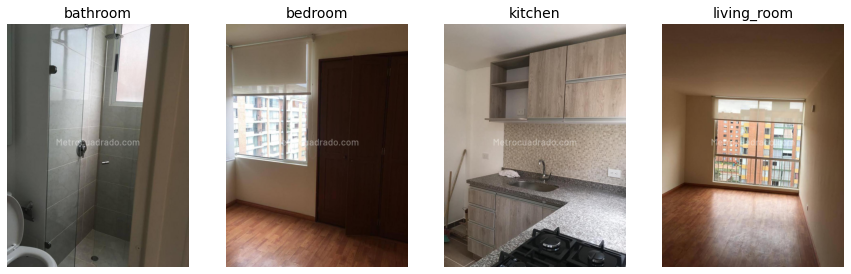

In [95]:
apto=0
filenames=[]
fig, axes = plt.subplots(1,4, figsize=(15,15))
for i in range(0,4):
    im = image.imread(df.iloc[apto,i+2])
    axes[i].imshow(im)
    axes[i].set_title(rooms[i],fontsize = 14)
    axes[i].axis("off")
    filenames.append(df.iloc[apto,i+2])

In [108]:
image_size = 256
training_sample_percentage = 0.9
training_item_count = int(len(df)*training_sample_percentage)
training_item_count

3

In [97]:
train_df = shuffle(df)
validation_df = train_df[training_item_count:]
train_df = train_df[:training_item_count]

In [98]:
def build_input_set(index,image_size=256):
    global df
    images = list(df.iloc[index,2:6])
    stacked_image = []
    
    for img in images:
        img_raw = tf.io.read_file(img)
        img = tf.io.decode_image(img_raw)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, [image_size,image_size])
        stacked_image.append(img[:,:,:3])
    
    return np.array(stacked_image)

In [99]:
def get_image_from(index, room, image_size=256 ):
    global df
    images = df["Path_"+room][index]
    img_raw = tf.io.read_file(images)
    img = tf.io.decode_image(img_raw)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [image_size,image_size])
    return np.array(img)

In [146]:
def data_set_builder_x1(y_values, tipo, batch_size=16):
    global train_df

    while True:
        for start in range(0,train_df.shape[0], batch_size):
            X_batch = []
            Y_batch = []
            end = min(start + batch_size, training_item_count)

            X_batch = np.asarray([get_image_from(index,tipo)/255. for index in range(start,end)]).astype('float32')
            Y_batch = np.asarray(y_values[start:end]).astype('float32')

            yield X_batch, Y_batch

In [266]:
def data_set_builder_x4(y_values, batch_size=16):
    global train_df

    while True:
        for start in range(0,train_df.shape[0], batch_size):
            X_batch = []
            Y_batch = []
            end = min(start + batch_size, training_item_count)
            
            X_batch = np.array([build_input_set(index)/255. for index in range(start,end)])
            input_image1 = X_batch[:,:,:,:,:]
            input_image2 = X_batch[:,::,:,:]
            input_image3 = X_batch[:,:,:,:,:]
            input_image4 = X_batch[:,:,:,:,:]
            
            Y_batch =  np.asarray((y_values[start:end]).astype('float32'))
            
            yield [input_image1,input_image2,input_image3], Y_batch

In [262]:
def data_set_builder_x4_1(y_values, batch_size=16):
    global train_df

    while True:
        for start in range(0,train_df.shape[0], batch_size):
            X_batch = []
            Y_batch = []
            end = min(start + batch_size, training_item_count)
            
            X_batch = np.array([build_input_set(index)/255. for index in range(start,end)])
            return X_batch

In [267]:
b=data_set_builder_x4_1(train_df["valorventa"], batch_size=16)
b.shape

(3, 4, 256, 256, 3)

In [268]:
gen = data_set_builder_x4(train_df["valorventa"], batch_size=16)

In [269]:
a= next(gen)
print(len(a[0]))
print(a[0][0].shape)
print(a[0][1].shape)
print(a[0][2].shape)
print(a[0][3].shape)

3
(3, 4, 256, 256, 3)
(3, 4, 256, 256, 3)
(3, 4, 256, 256, 3)


IndexError: list index out of range

In [ ]:
plt.imshow(images[0].permute(1, 2, 0))

In [214]:
i = build_input_set(0)
i.shape

(4, 256, 256, 3)

### Cración de las ramas

In [101]:
num_channel = 3
image_shape = (image_size, image_size, num_channel)

def branch(input_image):
    x = Conv2D(128, (3, 3))(input_image)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(32, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    
    x = layers.Dense(256)(x)
    x = Activation('relu')(x)
    
    return layers.Dropout(0.3)(x)

## Entrenamiento Ramas Convolucionales

#### Baños

In [175]:
room_type="bathroom"
brach_path="E:/TesisMA/Modelos/F2/Branch_bathroom/"

input_image_bathroom = Input(shape=image_shape)
core_branch_bathroom = branch(input_image_bathroom)
output_bathroom = Dense(1, activation='linear')(core_branch_bathroom)

branch_model_bathroom = Model(input_image_bathroom,output_bathroom)
branch_model_bathroom.compile(loss="mse", optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001))

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5),
             EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath=brach_path+'best_branch.h5', monitor='val_loss', save_best_only=True)]

batch_size = 1

train_gen = data_set_builder_x1(train_df["valorventa"],room_type, batch_size=batch_size)
val_gen=data_set_builder_x1(validation_df["valorventa"],room_type,batch_size=batch_size)

history = branch_model_bathroom.fit(train_gen,
                           steps_per_epoch = int(len(train_df)/batch_size),
                           validation_data= val_gen,
                           validation_steps= int(len(validation_df)/batch_size),
                           epochs=2,
                           callbacks=callbacks)

Epoch 1/2
3/3 [==============================] - 12s 2s/step - loss: 322499988925972480.0000 - val_loss: 202499994245136384.0000
Epoch 2/2
3/3 [==============================] - 6s 2s/step - loss: 322499988925972480.0000 - val_loss: 0.0000e+00


#### Cocinas

In [177]:
room_type="kitchen"
brach_path="E:/TesisMA/Modelos/F2/Branch_kitchen/"

input_image_kitchen = Input(shape=image_shape)
core_branch_kitchen = branch(input_image_kitchen)
output_kitchen = Dense(1, activation='linear')(core_branch_kitchen)

branch_model_kitchen = Model(input_image_kitchen,output_kitchen)
branch_model_kitchen.compile(loss="mse", optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001))

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5),
             EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath=brach_path+'best_branch.h5', monitor='val_loss', save_best_only=True)]

batch_size = 1

train_gen = data_set_builder_x1(train_df["valorventa"],room_type, batch_size=batch_size)
val_gen=data_set_builder_x1(validation_df["valorventa"],room_type,batch_size=batch_size)

history = branch_model_kitchen.fit(train_gen,
                           steps_per_epoch = int(len(train_df)/batch_size),
                           validation_data= val_gen,
                           validation_steps= int(len(validation_df)/batch_size),
                           epochs=2,
                           callbacks=callbacks)

Epoch 1/2
3/3 [==============================] - 12s 2s/step - loss: 322499988925972480.0000 - val_loss: 202499994245136384.0000
Epoch 2/2
3/3 [==============================] - 6s 2s/step - loss: 322499988925972480.0000 - val_loss: 0.0000e+00


#### Habitaciones

In [178]:
room_type="bedroom"
brach_path="E:/TesisMA/Modelos/F2/Branch_bedroom/"

input_image_bedroom = Input(shape=image_shape)
core_branch_bedroom = branch(input_image_bedroom)
output_bedroom = Dense(1, activation='linear')(core_branch_bedroom)

branch_model_bedroom = Model(input_image_bedroom,output_bedroom)
branch_model_bedroom.compile(loss="mse", optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001))

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5),
             EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath=brach_path+'best_branch.h5', monitor='val_loss', save_best_only=True)]

batch_size = 1

train_gen = data_set_builder_x1(train_df["valorventa"],room_type, batch_size=batch_size)
val_gen=data_set_builder_x1(validation_df["valorventa"],room_type,batch_size=batch_size)

history = branch_model_bedroom.fit(train_gen,
                           steps_per_epoch = int(len(train_df)/batch_size),
                           validation_data= val_gen,
                           validation_steps= int(len(validation_df)/batch_size),
                           epochs=2,
                           callbacks=callbacks)

Epoch 1/2
3/3 [==============================] - 11s 2s/step - loss: 322499988925972480.0000 - val_loss: 202499994245136384.0000
Epoch 2/2
3/3 [==============================] - 6s 2s/step - loss: 322499988925972480.0000 - val_loss: 0.0000e+00


#### Salas

In [179]:
room_type="living_room"
brach_path="E:/TesisMA/Modelos/F2/Branch_living_room/"

input_image_living_room = Input(shape=image_shape)
core_branch_living_room= branch(input_image_living_room)
output_living_room= Dense(1, activation='linear')(core_branch_living_room)

branch_model_living_room = Model(input_image_living_room,output_living_room)
branch_model_living_room.compile(loss="mse", optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001))

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5),
             EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath=brach_path+'best_branch.h5', monitor='val_loss', save_best_only=True)]

batch_size = 1

train_gen = data_set_builder_x1(train_df["valorventa"],room_type, batch_size=batch_size)
val_gen=data_set_builder_x1(validation_df["valorventa"],room_type,batch_size=batch_size)

history = branch_model_living_room.fit(train_gen,
                           steps_per_epoch = int(len(train_df)/batch_size),
                           validation_data= val_gen,
                           validation_steps= int(len(validation_df)/batch_size),
                           epochs=2,
                           callbacks=callbacks)

Epoch 1/2
3/3 [==============================] - 14s 3s/step - loss: 322499988925972480.0000 - val_loss: 202499994245136384.0000
Epoch 2/2
3/3 [==============================] - 8s 3s/step - loss: 322499988925972480.0000 - val_loss: 0.0000e+00


## Red  Neuronal Completa 

In [190]:
def input_branch(input_image, tipo):
    input_image = Input(shape=image_shape)
    core_branch = branch(input_image)
    output = Dense(1, activation='linear')(core_branch)
    branch_model = Model(input_image,output)
    branch_model.load_weights("E:/TesisMA/Modelos/F2/Branch_"+tipo+"/best_branch.h5")
        
    new_branch = Model(inputs=branch_model.input, outputs=branch_model.layers[-2].output)
    
    for layer in new_branch.layers[:-3]:
        layer.trainable = False
    
    return new_branch

In [191]:
input_image1 = Input(shape=image_shape)
input_image2 = Input(shape=image_shape)
input_image3 = Input(shape=image_shape)
input_image4 = Input(shape=image_shape)

first_branch = branch(input_image1)
second_branch = branch(input_image2)
third_branch = branch(input_image3)
fourth_branch =branch(input_image4)

merge = layers.Concatenate(axis=-1)([first_branch,second_branch,third_branch,fourth_branch])
dense = layers.Dense(256)(merge)
dropout = layers.Dropout(0.3)(dense)
output = layers.Dense(1)(dropout)

model = Model([input_image1,input_image2,input_image3,input_image4],output)
model.compile(loss='mse' ,optimizer=tf.keras.optimizers.RMSprop(0.001))

In [209]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5),
             EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='E:/TesisMA/Modelos/F2/Price_Prediction'+'best_model.h5', monitor='val_loss', save_best_only=True)]

batch_size = 1
history = model.fit(data_set_builder_x4(train_df["valorventa"], batch_size=batch_size),
                        steps_per_epoch = int(len(train_df)/batch_size),
                        validation_data=data_set_builder_x4(validation_df["valorventa"], batch_size=batch_size),
                        validation_steps=int(len(validation_df)/batch_size),
                        epochs=3,
                        callbacks=callbacks)

IndexError: index 1 is out of bounds for axis 0 with size 1